# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [2]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [388]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0) #sheetname deprecated
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [17]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [18]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
customer_name    324 non-null object
offer_id         324 non-null int64
n                324 non-null int64
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


In [77]:
df_transactions.customer_name.nunique(), df_transactions.offer_id.nunique()

(100, 32)

The new data frame will have 100 rows each for each customer and 33 columns, one for customer name and the others for offer ids.

In [65]:
df_customer = pd.pivot_table(df_transactions, index='customer_name', 
                             columns='offer_id', values='n', fill_value=0).reset_index()
df_customer.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [71]:
df_customer.columns.name

'offer_id'

I want to remove 'offer_id', the title (name) of columns

In [72]:
df_customer.columns.name = None

In [81]:
df_customer.head()

,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [45]:
# number of rows and columns
len(df_customer), len(df_customer.columns)

(100, 33)

In [95]:
# number of 1's = number of transactions?
df_customer.iloc[:,1:].sum().sum() == len(df_transactions)

True

In [93]:
# check one customer data
df_customer.iloc[0,1:].sum() == len(df_transactions[df_transactions.customer_name=='Adams'])

True

Yes, I found the new dataframe has the right number of 1's.

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

__What values of  SS  do you believe represent better clusterings? Why?__

For a given number of clusters, smaller SS represents better clusterings because smaller SS occurs when points are closer to the centroids of the clusters the points belong to. If the number of clusters varies, it is not simple to say which SS values represent better clusterings. We hope to find SS not too big and not too small. If increasing a number of clusters make a huge improvemnt (i.e., drop) in SS, it is usually better to increase the number of clusters. SS always decreases as a number of clusters increases. However, too many clusters are hard to interprete and we don't want to further divide a dense cluster into two. Thus, we have to use some methods such as Elblow method or Silhouette method to chosse a number of clusters.

In [97]:
x_cols = df_customer.iloc[:,1:].values

In [104]:
from sklearn.cluster import KMeans

In [229]:
Ks = range(1,10)
SS = []
for k in Ks:
    kmean = KMeans(n_clusters=k, random_state=10)
    kmean.fit(x_cols)
    SS.append(kmean.inertia_)

I made K start from 1 instead of 2 for easir decision of the best K.

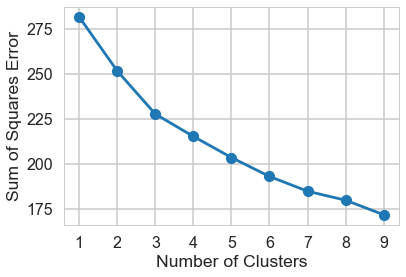

In [230]:
plt.plot(Ks, SS, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares Error')
plt.xticks(Ks)
plt.show()

I would pick 3 for the best number of clusters (K) since decrease in SS seems to slow down after K=3. 

In [149]:
labels = KMeans(n_clusters=3).fit_predict(x_cols)

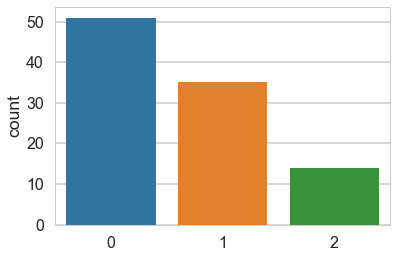

In [150]:
ax = sns.countplot(labels)

__What challenges did you experience using the Elbow method to pick  KK ?__

I had difficulty with deciding the best K since it is hard to find an elbow in the plot of SS as a function of K. Decrease in SS seems to slow down after 3, but SS continues to drop in a similar speed and a little bigger drop appears between 6 and 7.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

Since all features values in the current data, x_cols, are either 0 or 1, the right plots in the article with the first two features as x and y axis cannot visualize clusters of the current data. Thus, I will use t-SNE to visualize clusters instead. The centers of clusters plotted in the article are omitted since adding those centers are impossible in t-SNE plots (transfrom() method is not available in sklearn.TSNE)

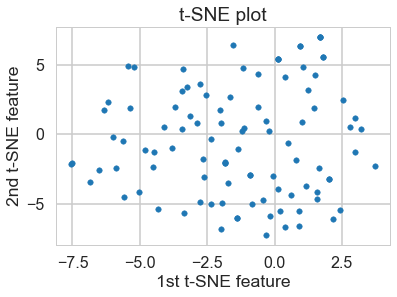

In [227]:
# t-SNE plot using the first and second t-SNE features
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate=100, random_state=42)
tsne_features = tsne.fit_transform(x_cols)
tsne_0 = tsne_features[:,0]
tsne_1 = tsne_features[:,1]
plt.scatter(tsne_0,tsne_1, s=30)
plt.xlabel('1st t-SNE feature')
plt.ylabel('2nd t-SNE feature')
plt.title('t-SNE plot')
plt.show()

n_clusters: 2 Silhouette_score: 0.0937
n_clusters: 3 Silhouette_score: 0.1189
n_clusters: 4 Silhouette_score: 0.1235
n_clusters: 5 Silhouette_score: 0.1409
n_clusters: 6 Silhouette_score: 0.1372
n_clusters: 7 Silhouette_score: 0.1161
n_clusters: 8 Silhouette_score: 0.1134
n_clusters: 9 Silhouette_score: 0.1251


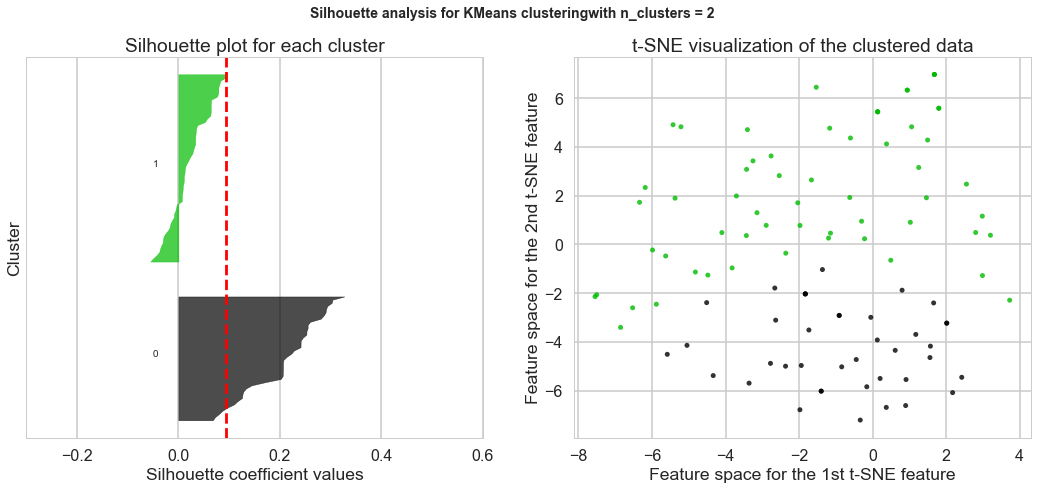

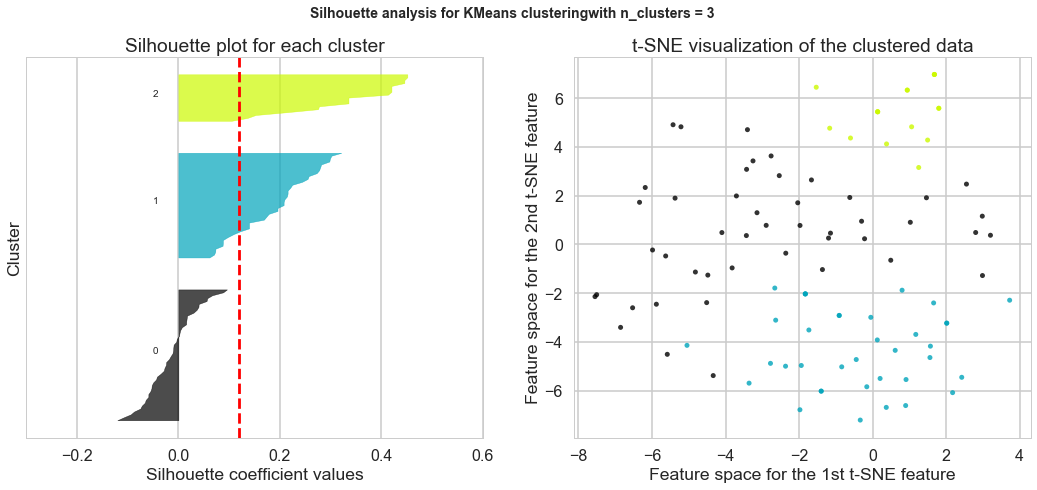

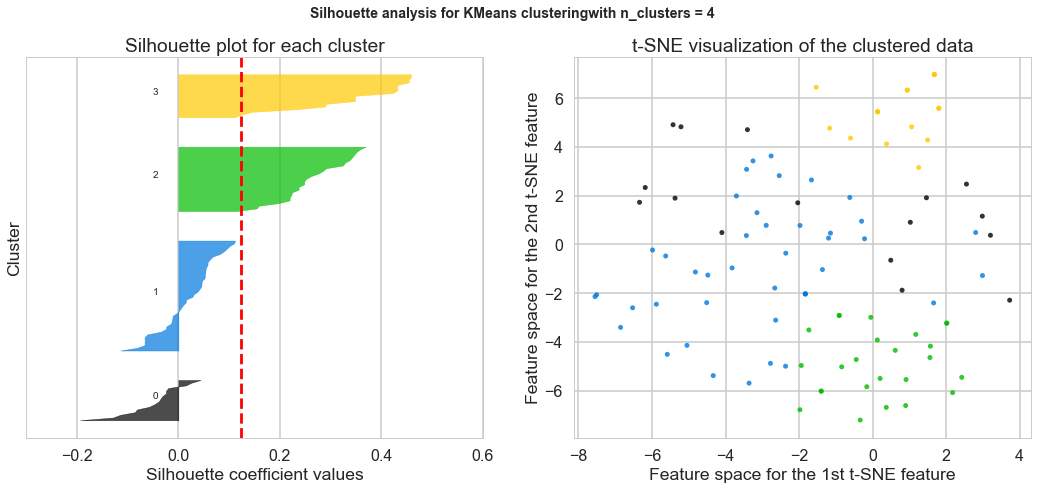

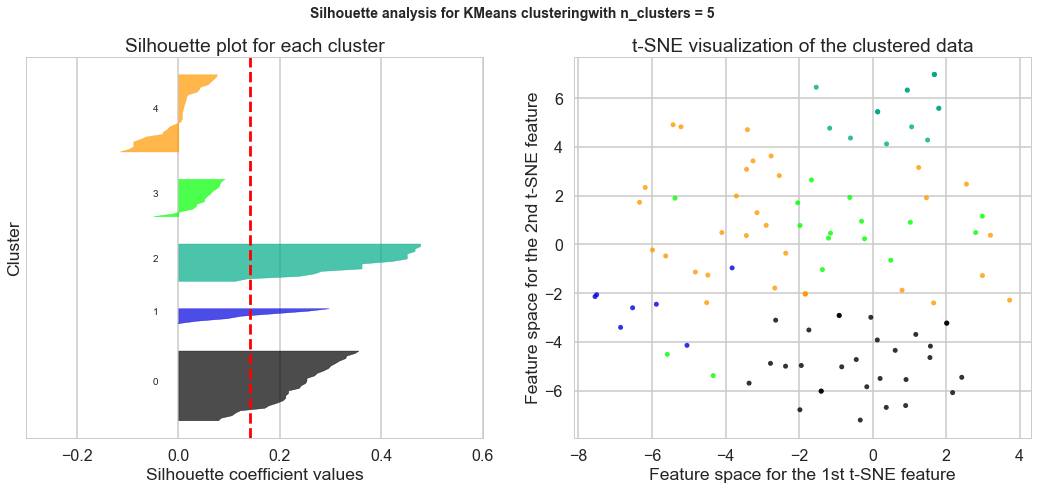

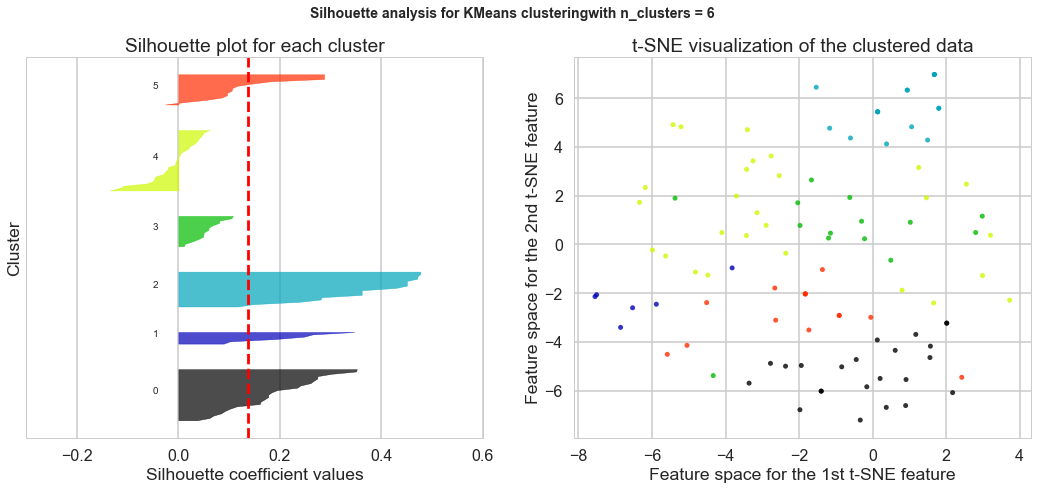

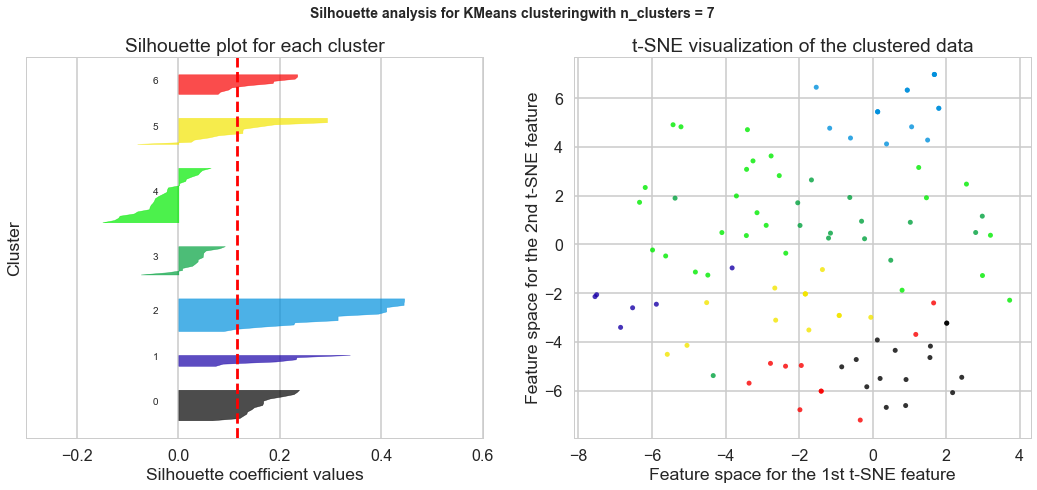

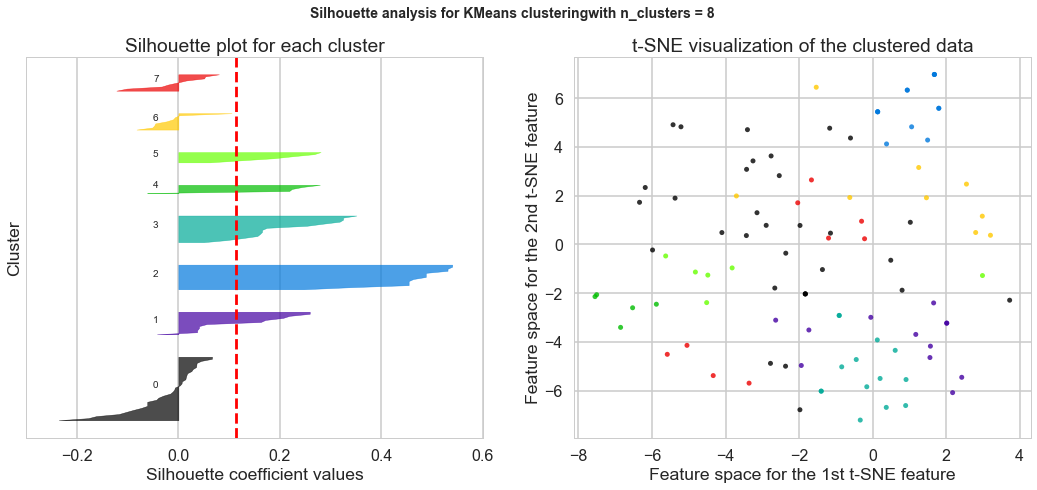

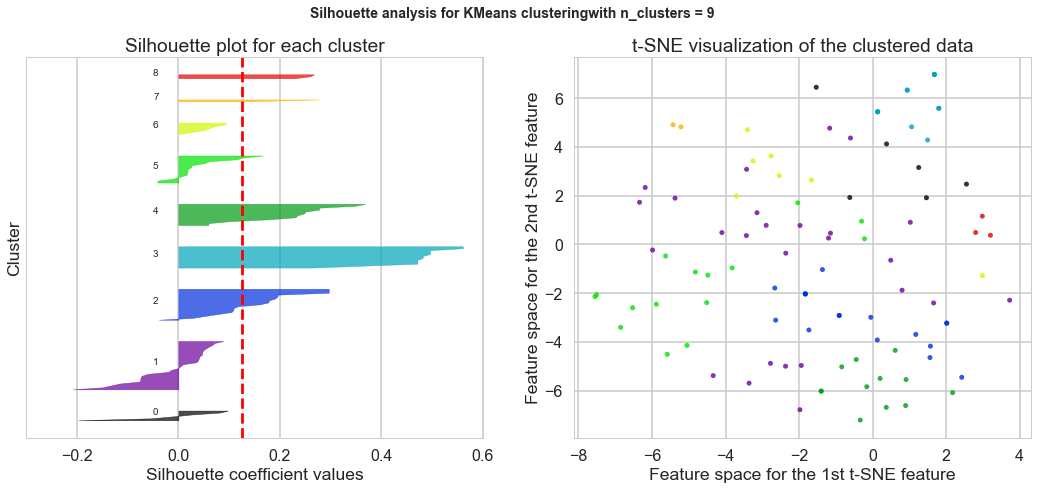

In [461]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

X = x_cols

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
silhouette_scores =[]

for n_clusters in range_n_clusters:
    # subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.3, 0.6])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("n_clusters:", n_clusters,
          "Silhouette_score:", round(silhouette_avg,4))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for each cluster")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6])

    # 2nd Plot showing the actual clusters formed with TSNE
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(tsne_0, tsne_1, marker='.', s=100, lw=0, alpha=0.8,
                c=colors, edgecolor='k')

    ax2.set_title("t-SNE visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st t-SNE feature")
    ax2.set_ylabel("Feature space for the 2nd t-SNE feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering"
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

- The Silhouette plots (left) show clusters start to overlap from the begining (n_clusters=2). The Silhouette coefficient values for all clusters show there are no substantial structure or weak structures.
- The average Silhouette scores (red dotted line) are less than 0.2 for every number of clusters.
- The t-SNE graphs (right) also show weak clustering and clusters are mixed substantionally from n_clusters=4.

In [504]:
# average silhouette score for each  K
silhouette_scores

[0.09365573283492713,
 0.11889942863638556,
 0.12347053919571699,
 0.14092516241984757,
 0.1371798939109807,
 0.1161092456616906,
 0.11339573832632867,
 0.12505960527779877]

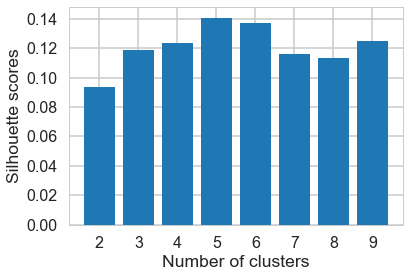

In [215]:
# plot of average silhouette scores
plt.bar(range_n_clusters, silhouette_scores)
plt.yticks([0,0.02,0.04,0.06,0.08,0.1,0.12,0.14])
plt.xticks(range_n_clusters)
plt.ylabel('Silhouette scores')
plt.xlabel('Number of clusters')
plt.show()

- The average silhouette score is the best when the number of clusters is 5.
- This is different from the best number of clusters, 3, I found using the elbow method. I had hard time deciding the best K using the elbow method for this data, but the silhouette method seems to be more straight forward to decide the best K.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [248]:
from sklearn.decomposition import PCA

In [287]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(x_cols)

In [288]:
# Create clutsters using Kmeans
clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(X)

In [289]:
# Make a dataframe described above
df_pca = pd.DataFrame({'customer_name':df_customer.customer_name, 'cluster_id': cluster_labels,
             'x':pca_features[:,0], 'y':pca_features[:,1]})

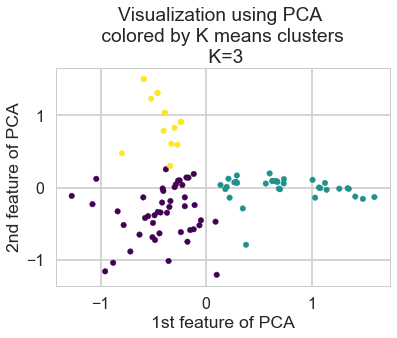

In [290]:
# Make a scatter plot with the 2 PCA features colored by cluster ids
plt.scatter('x', 'y', data=df_pca, s=30, c='cluster_id', cmap='viridis')
plt.xlabel('1st feature of PCA')
plt.ylabel('2nd feature of PCA')
plt.title('Visualization using PCA \n colored by K means clusters \n K=3')
plt.show()

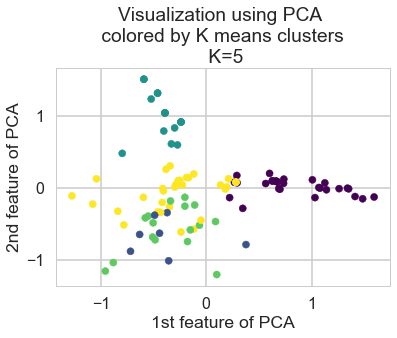

In [291]:
# Create clutsters using Kmeans
clusterer = KMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(X)
# Make a scatter plot with the 2 PCA features colored by cluster ids
plt.scatter('x', 'y', data=df_pca, s=50, c=cluster_labels, cmap='viridis')
plt.xlabel('1st feature of PCA')
plt.ylabel('2nd feature of PCA')
plt.title('Visualization using PCA \n colored by K means clusters \n K=5')
plt.show()

- The tow new features created by PCA show some clusters. They are not stronly separated clusters, but there are not much ovelapping at least.
- I tried several values for the number of clusters K and it seems 3 is the best value for K. The K values bigger than 3 made  different clusters overlap (see the second plot for K=5 case) 
- The elbow method, t-SNE plots, and PCA plots (but not silhouette scores) all gave the same optimal value for K, but the PCA  method seems to have visually shown the optimal value for K the best. 

__Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?__

In [282]:
# Add cluster_id column to df_customer
df_customer['cluster_id'] = df_pca['cluster_id']
# Separate df_customer by cluster_id
customers_0 = df_customer[df_customer.cluster_id == 0]
customers_1 = df_customer[df_customer.cluster_id == 1]
customers_2 = df_customer[df_customer.cluster_id == 2]

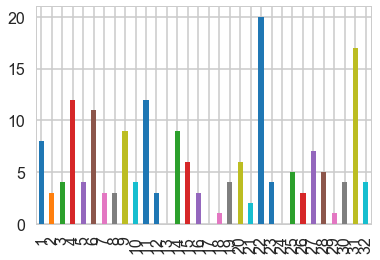

In [297]:
customers_0.iloc[:,1:-1].sum().plot(kind='bar')
plt.show()

In [314]:
df_offers[(df_offers.offer_id==22)|(df_offers.offer_id==31)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
21,22,August,Champagne,72,63,France,False
30,31,December,Champagne,72,89,France,False


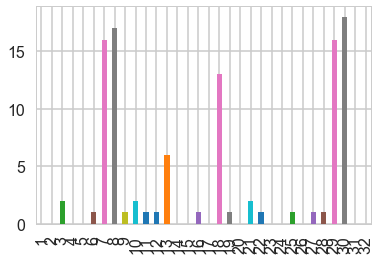

In [298]:
customers_1.iloc[:,1:-1].sum().plot(kind='bar')
plt.show()

In [311]:
df_offers[(df_offers.offer_id==7)|(df_offers.offer_id==8)|(df_offers.offer_id==18)|
          (df_offers.offer_id==29)|(df_offers.offer_id==30)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
17,18,July,Espumante,6,50,Oregon,False
28,29,November,Pinot Grigio,6,87,France,False
29,30,December,Malbec,6,54,France,False


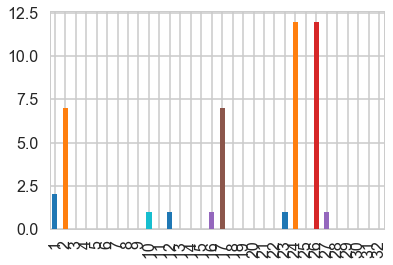

In [299]:
customers_2.iloc[:,1:-1].sum().plot(kind='bar')
plt.show()

In [312]:
df_offers[(df_offers.offer_id==2)|(df_offers.offer_id==17)|
          (df_offers.offer_id==24)|(df_offers.offer_id==26)]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
1,2,January,Pinot Noir,72,17,France,False
16,17,July,Pinot Noir,12,47,Germany,False
23,24,September,Pinot Noir,6,34,Italy,False
25,26,October,Pinot Noir,144,83,Australia,False


- I checked popular offers in each cluster and found popular offers in each of cluster 0 and 2 are related to a single wine varietal (Champagne for cluster 0 and Pinot Noir for cluster 2). 
- The popular offers for Cluster 1 customers are related several varietals. This cluster probably represents customers who enjoy various types of wines, but there were 4 varietals liked by those customers much more than other varietals. The 4 varietals do not overlap with the varietals liked by other clusters.
- This pattern will be checkd using different plots below.

I will first make a data frame df_all that has all the information together by merging df_offers and df_customers into df_transactions. This new dataframe will be used to plot the count of transactions for each varietal for each cluster.

In [360]:
df_all = df_transactions.merge(df_offers, how='left', on='offer_id').merge(df_customer[['customer_name','cluster_id']],how='left', on='customer_name')
df_all.head(5)

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster_id
0,Smith,2,1,January,Pinot Noir,72,17,France,False,2
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False,2
2,Johnson,17,1,July,Pinot Noir,12,47,Germany,False,2
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False,2
4,Johnson,26,1,October,Pinot Noir,144,83,Australia,False,2


In [362]:
df_offers.varietal.unique()

array(['Malbec', 'Pinot Noir', 'Espumante', 'Champagne',
       'Cabernet Sauvignon', 'Prosecco', 'Chardonnay', 'Merlot',
       'Pinot Grigio'], dtype=object)

In [357]:
# Make 'varietal' column categorical 
# This will keep the order of varietal the same in the below plots
df_all.varietal = pd.Categorical(df_all.varietal)

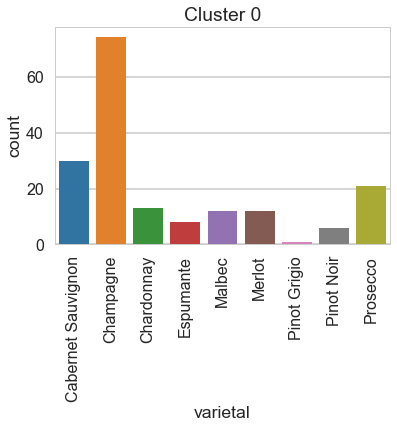

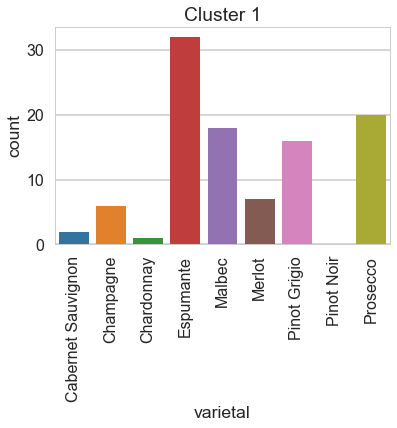

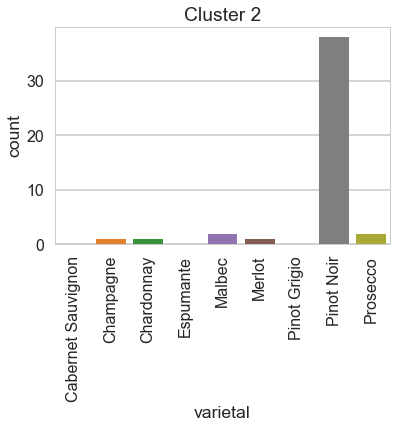

In [359]:
for cluster in range(0,3):
    ax = sns.countplot('varietal', data=df_all[df_all.cluster_id==cluster])
    plt.title('Cluster '+str(cluster))
    plt.xticks(rotation=90)
    plt.show()

These plots confirmed my findings above, but these plots more clearly show the varietals preferred by each cluster.
- The customes in cluster 0 like Champagne.
- The customes in cluster 1 like Malbec, Espumante, Prosecco, and Pinot Grigio.
- The customes in cluster 2 like Pinot Noir.

In [ ]:
# Repeat with 5 clusters (worse!!!)
#clusterer = KMeans(n_clusters=5, random_state=10)
#cluster_labels = clusterer.fit_predict(X)
#df_customer['cluster_id_5clusters'] = cluster_labels
#df_all_5clusters = df_transactions.merge(df_offers, how='left', on='offer_id').merge(df_customer[['customer_name', 'cluster_id_5clusters']],how='left', on='customer_name')
#
#for cluster in range(0,5):
#    ax = sns.countplot('varietal', data=df_all[df_all.cluster_id_5clusters==cluster])
#    plt.title('Cluster '+str(cluster))
#    plt.xticks(rotation=90)
#    plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [390]:
X = x_cols

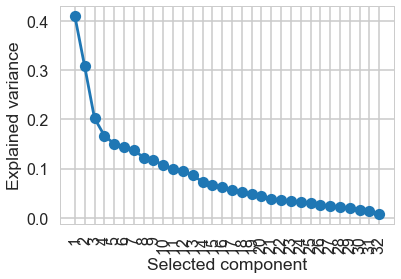

In [391]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)
plt.plot(range(1,len(pca.explained_variance_)+1), pca.explained_variance_, '-o')
plt.xticks(range(1,len(pca.explained_variance_)+1), rotation=90)
plt.xlabel('Selected component')
plt.ylabel('Explained variance')
plt.show()

The elbow point is around 4. Thus, 4 is one possible value for the optimal number of dimensions for PCA.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [392]:
X= x_cols

In [408]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)
x = pca_features[:,0]
y = pca_features[:,1]

In [521]:
# Make a function to create a scatter plot with the 2 PCA features 
# colored by given cluster labels
def pca_plot(feature_1, feature_2, cluster_labels, clustering_name):
    plt.scatter(feature_1, feature_2, s=30, c=cluster_labels, cmap='viridis', alpha=.5)
    plt.xlabel('1st feature of PCA')
    plt.ylabel('2nd feature of PCA')
    plt.title('Visualization using PCA \n colored by {} clusters'.format(clustering_name))
    plt.show()

#### 1. Affinity propagation

In [400]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

Clusterer: AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=-30, verbose=False)
N_clusters: 3


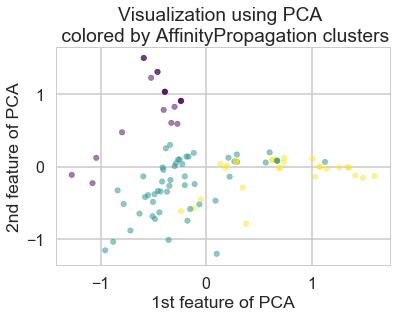

In [522]:
clusterer = AffinityPropagation(preference=-30, damping = .5)
clusterer.fit(X)  
print('Clusterer:', clusterer)
labels = clusterer.labels_
print('N_clusters:', len(clusterer.cluster_centers_indices_))
pca_plot(x, y, labels, 'AffinityPropagation')

In [511]:
preferences = [-35,-30,-20, -10]
damping = [.5,.6,.7]
for pref in preferences:
    for damp in damping:
        clusterer = AffinityPropagation(preference=pref, damping = damp)
        clusterer.fit(X)
        print('Preference:', pref, 'Damping:', damp)
        labels = clusterer.labels_
        print('N_clusters:', len(clusterer.cluster_centers_indices_),"Silhouette_score:", round(silhouette_score(X, labels),4))
        print()

Preference: -35 Damping: 0.5
N_clusters: 2 Silhouette_score: 0.0801

Preference: -35 Damping: 0.6
N_clusters: 2 Silhouette_score: 0.0572

Preference: -35 Damping: 0.7
N_clusters: 2 Silhouette_score: 0.0572

Preference: -30 Damping: 0.5
N_clusters: 3 Silhouette_score: 0.1079

Preference: -30 Damping: 0.6
N_clusters: 3 Silhouette_score: 0.1079

Preference: -30 Damping: 0.7
N_clusters: 3 Silhouette_score: 0.1079

Preference: -20 Damping: 0.5
N_clusters: 4 Silhouette_score: 0.0859

Preference: -20 Damping: 0.6
N_clusters: 4 Silhouette_score: 0.0859

Preference: -20 Damping: 0.7
N_clusters: 4 Silhouette_score: 0.0859

Preference: -10 Damping: 0.5
N_clusters: 9 Silhouette_score: 0.0918

Preference: -10 Damping: 0.6
N_clusters: 9 Silhouette_score: 0.1104

Preference: -10 Damping: 0.7
N_clusters: 7 Silhouette_score: 0.0274



Affinity propagation clustering does not require to fix the number of clusters. With the default setting, it creates too many clusters (14!!). I tried many values for the preference and damping parameters (more than above) and found preference -30 with dampling value -5 makes higher silhoutette score and less overlapping 3 clusters, which I found as optimal number of clusters earlier. The damping values from .5 (default) to .7 gave similar results. I was able to make higher silhouette scores with higher preference values, but the number of clusters were too high (e.g., Preference: -10 Damping: 0.6 N_clusters: 9 Silhouette_score: 0.1104). It was more difficult to find the best parameter values than k-means clustering and the performance was even worse; the customers in different clusters overlap in the PCA plot and the average silhouette score is lower. Thus, Affinity propagation does not seem to be an ideal clustering method for this type of data (with a few clusters).

#### 2. Spectral clustering

In [486]:
from sklearn.cluster import SpectralClustering

Clusterer: SpectralClustering(affinity='rbf', assign_labels='discretize', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=3, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=10)
N_clusters: 3


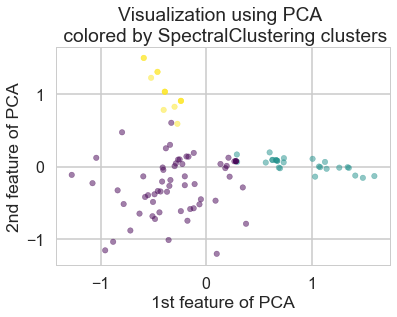

In [523]:
n_cluster = 3
clusterer = SpectralClustering(n_clusters=n_cluster, assign_labels="discretize", random_state=10).fit(X)
clusterer.fit(X)  #fit_predict() also works
print('Clusterer:', clusterer)
labels = clusterer.labels_
print('N_clusters:',n_cluster)
pca_plot(x, y, labels, 'SpectralClustering')

In [508]:
# Silhouette method
for n_cluster in range(2,10):
    clusterer = SpectralClustering(n_clusters=n_cluster, assign_labels="discretize", random_state=10)
    clusterer.fit(X)
    labels = clusterer.labels_
    print('N_clusters:', n_cluster)
    print("Silhouette_score:", round(silhouette_score(X, labels),4))

N_clusters: 2
Silhouette_score: 0.0789
N_clusters: 3
Silhouette_score: 0.1037
N_clusters: 4
Silhouette_score: 0.0767
N_clusters: 5
Silhouette_score: 0.0885
N_clusters: 6
Silhouette_score: 0.0729
N_clusters: 7
Silhouette_score: 0.0646
N_clusters: 8
Silhouette_score: 0.0738
N_clusters: 9
Silhouette_score: 0.0814


For spectral clustering, 3 clusters again give the best silhouette score 0.1037 and show good clustering in the PCA plot. The 3 clusters are similar to k-means, but not the same. The average silhouette score for spectral clustering with 3 clusters is a little lower than the scores for the k-means (0.1189) and also for affinity propagation (0.1079). However, the PCA plot shows that spectral clustering makes much less overlapping clusters than affinity propagation.

#### 3. Agglomerative clustering

In [515]:
from sklearn.cluster import AgglomerativeClustering

Clusterer: AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func=<function mean at 0x00000242BABACB70>)
N_clusters: 3


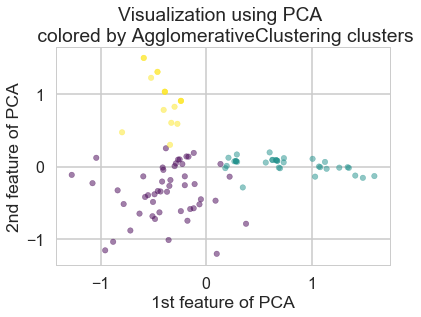

In [528]:
n_cluster = 3
clusterer = AgglomerativeClustering(n_clusters=n_cluster).fit(X)
clusterer.fit(X)  #fit_predict() also works
print('Clusterer:', clusterer)
labels = clusterer.labels_
print('N_clusters:',n_cluster)
pca_plot(x, y, labels, 'AgglomerativeClustering')

In [519]:
# Silhouette method
for n_cluster in range(2,10):
    clusterer = AgglomerativeClustering(n_clusters=n_cluster)
    clusterer.fit(X)
    labels = clusterer.labels_
    print('N_clusters:', n_cluster)
    print("Silhouette_score:", round(silhouette_score(X, labels),4))

N_clusters: 2
Silhouette_score: 0.0826
N_clusters: 3
Silhouette_score: 0.1163
N_clusters: 4
Silhouette_score: 0.1289
N_clusters: 5
Silhouette_score: 0.1409
N_clusters: 6
Silhouette_score: 0.1472
N_clusters: 7
Silhouette_score: 0.1528
N_clusters: 8
Silhouette_score: 0.1558
N_clusters: 9
Silhouette_score: 0.1208


For 3 agglomerative clustering, 3 clusters again show good not overlapping clustering in the PCA plot. The 3 clusters are similar to k-means and spectral clustering, but not the same. The average silhouette score for agglomerative clustering keeps increasing as the number of clusters increases until N_clusters = 8 and it (0.1558) is the highest among the all silhouette scores I have seen above. The score for 3 clusters (0.1163) is also almost as big as the score for the k-means method (0.1189) which was the best so far for 3 clusters. Agglomerative clustering seems to work better for data with many clusters, but its performance is also good for data with smaller numbers of clusters in our case.

#### 4. DBSCAN

In [529]:
from sklearn.cluster import DBSCAN

In [634]:
# Silhouette method
eps = [1.7,1.8,2]
min_samples = [2,3,4]
for ep in eps:
    for min_sample in min_samples:
        clusterer = DBSCAN(eps=ep, min_samples=min_sample)
        clusterer.fit(X)
        print('eps:', ep, 'min_samples:', min_sample)
        labels = clusterer.labels_
        print('N_clusters:', len(set(labels)),
              "Silhouette_score:", round(silhouette_score(X, labels),4))

eps: 1.7 min_samples: 2
N_clusters: 4 Silhouette_score: 0.095
eps: 1.7 min_samples: 3
N_clusters: 2 Silhouette_score: 0.1321
eps: 1.7 min_samples: 4
N_clusters: 2 Silhouette_score: 0.1218
eps: 1.8 min_samples: 2
N_clusters: 2 Silhouette_score: 0.1802
eps: 1.8 min_samples: 3
N_clusters: 2 Silhouette_score: 0.1802
eps: 1.8 min_samples: 4
N_clusters: 2 Silhouette_score: 0.1802
eps: 2 min_samples: 2
N_clusters: 2 Silhouette_score: 0.2349
eps: 2 min_samples: 3
N_clusters: 2 Silhouette_score: 0.2349
eps: 2 min_samples: 4
N_clusters: 2 Silhouette_score: 0.2349


It was somewhat hard to find good parameter vaules for DBSCAN. The above shows some interesting parameter values that give good silhouette scores. I will show 3 of them with PCA plots below.

In [629]:
def DBSCAN_PCA_plot(eps=None, min_samples=None):
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    clusterer.fit(X)  #fit_predict() also works
    #print('Clusterer:', clusterer)
    labels = clusterer.labels_
    print('N_clusters:', len(set(labels)))
    print("Silhouette_score:", round(silhouette_score(X, labels),4))
    pca_plot(x, y, labels, 'DBSCAN')

N_clusters: 2
Silhouette_score: 0.2349


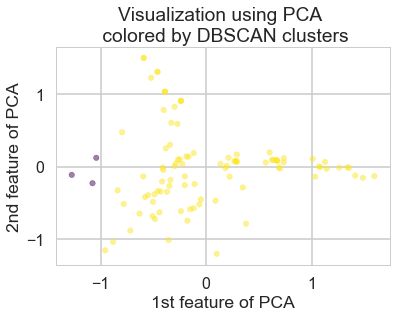

In [630]:
DBSCAN_PCA_plot(eps=2, min_samples=3)

This combination of parameters gave the best silhouette score 0.2349, but the corresponding PCA plot shows the high score was high by making the 2 cluster sizes very uneven. These clusters are not optimal. Thus, the silhouette method doesn't seem to work well for DBSCAN.

N_clusters: 2
Silhouette_score: 0.1321


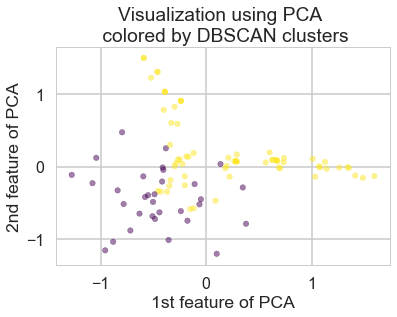

In [631]:
DBSCAN_PCA_plot(eps=1.7, min_samples=3)

This combination of parameter values gave much lower silhouette score (0.1321), but the PCA plot shows these two clusters are better than above.

N_clusters: 4
Silhouette_score: 0.095


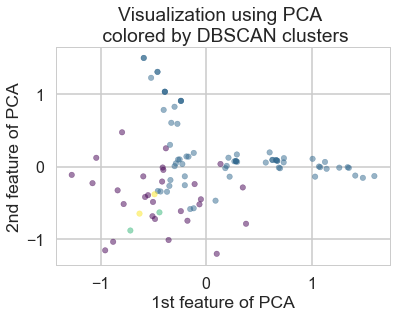

In [635]:
DBSCAN_PCA_plot(eps=1.7, min_samples=2)

I could not find parameter values that give 3 clusters, but 4 or more clusters were easily made and they were all overlapping clusters with uneven sizes like above. I found the DBSCAN clustering performs the worst for the current data among the 4 clustering methods.

The 4 clustering methods were already compared after each method. In summary, I found agglomerative clustering outperforms the other 3 methods since its PCA plot showed the least overlapping 3 clusters and its average silhouette score for 3 clusters was the highest. 